In [ ]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import jax
jax.config.update('jax_platform_name', 'cpu')

platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)

Platform:  cpu


In [6]:
len(jax.devices())

28

In [3]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import e_step_par, add0
from jax import grad, hessian
import matplotlib.pyplot as plt

### Clean-up E-Step for fitting Gaussian obs model with jax

In [7]:
from cohlib.utils import pickle_save, gamma_root, pickle_open
from cohlib.jax.gamma_create import k2_full

In [148]:
flow = 1
fhigh = 100
scalep_target = 5
scalep_offtarget = 2
k2_full(flow, fhigh, scalep_target, scalep_offtarget)

In [149]:
# gamma_name = 'k2-single-10'
# gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pickle")
gamma_load = pickle_open(f'gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

rk = jr.key(7)
# gamma_perturb = gamma_full[nz,:,:] + jnp.stack([jnp.eye(K) for _ in range(nz.size)])*(jr.normal(rk, nz.shape)*jnp.sqrt(10**scalep_offtarget)*50)[:,None,None]
# gamma_full = gamma_full.at[nz,:,:].set(gamma_perturb)


L = 50
zs = sample_from_gamma(rk, gamma_full, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)


In [150]:
gamma_full[9]

Array([[500000.     +0.j, 100000.-100000.j],
       [100000.+100000.j, 500000.     +0.j]], dtype=complex64)

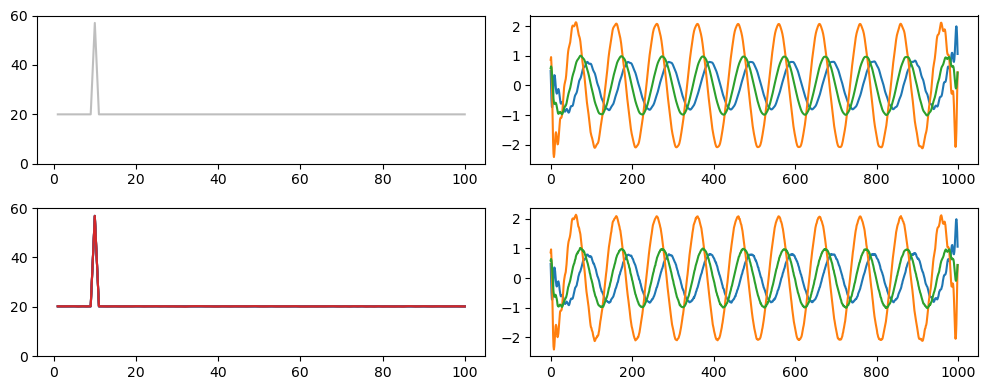

In [158]:
o1 = 1
o2 = -4 
obs_var = o1 * 10**o2
obs = xs + jr.normal(rk, xs.shape)*jnp.sqrt(obs_var)

oracle_est = jnp.einsum('jkl,jil->jkil', zs, zs.conj()).mean(-1)
obs_f = jnp.fft.rfft(obs, axis=0)
zs_naive = obs_f[1:,:,:]
naive_est = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

dB = True
fig, ax = plt.subplots(2,2,figsize=(10,4))
S_true = gamma_full[nz,0,0].real
S_oracle = oracle_est[nz,0,0].real
S_naive = naive_est[nz,0,0].real
# ax[1,0].plot(S_true, color='tab:grey', alpha=0.5)

if dB == True:
    S_true = 10*jnp.log10(S_true+1e-15)
    S_oracle = 10*jnp.log10(S_oracle+1e-15)
    S_naive = 10*jnp.log10(S_naive+1e-15)

ax[0,0].plot(freqs[nz], S_true, color='tab:grey', alpha=0.5)
for l in range(3):
    ax[1,0].plot(freqs[nz], S_oracle, color='tab:blue')
    ax[1,0].plot(freqs[nz], S_naive, color='tab:red')
    ax[0,1].plot(xs[:,0,l])
    ax[1,1].plot(obs[:,0,l])
ax[0,0].set_ylim([0,60])
ax[1,0].set_ylim([0,60])
plt.tight_layout()


(0.0, 2000.0)

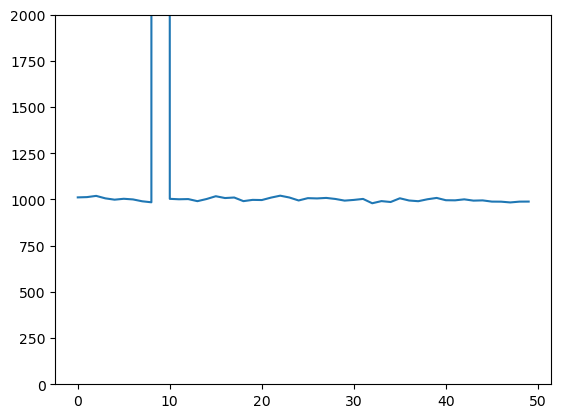

In [66]:
plt.plot(gamma_perturb[:,0,0].real) 
plt.ylim([0,2000])

In [25]:
freqs[nz]

Array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],      dtype=int32)

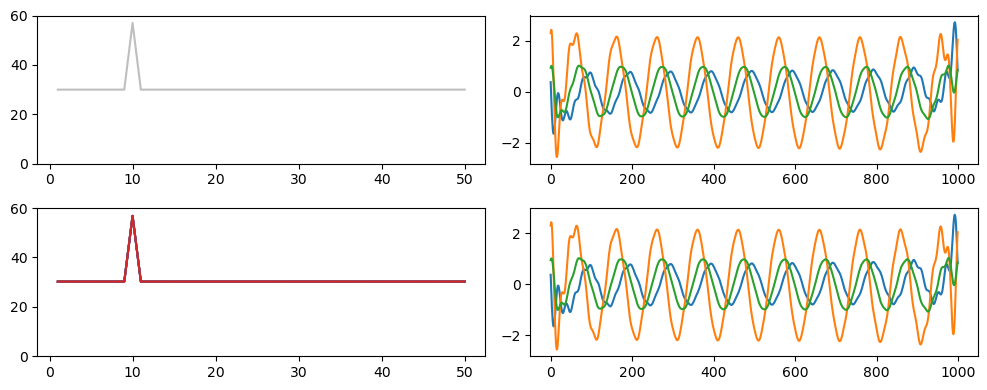

In [26]:
o1 = 1
o2 = -5 
obs_var = o1 * 10**o2
obs = xs + jr.normal(rk, xs.shape)*jnp.sqrt(obs_var)

oracle_est = jnp.einsum('jkl,jil->jkil', zs, zs.conj()).mean(-1)
obs_f = jnp.fft.rfft(obs, axis=0)
zs_naive = obs_f[1:,:,:]
naive_est = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

dB = True
fig, ax = plt.subplots(2,2,figsize=(10,4))
S_true = gamma_full[nz,0,0].real
S_oracle = oracle_est[nz,0,0].real
S_naive = naive_est[nz,0,0].real
# ax[1,0].plot(S_true, color='tab:grey', alpha=0.5)

if dB == True:
    S_true = 10*jnp.log10(S_true+1e-15)
    S_oracle = 10*jnp.log10(S_oracle+1e-15)
    S_naive = 10*jnp.log10(S_naive+1e-15)

ax[0,0].plot(freqs[nz], S_true, color='tab:grey', alpha=0.5)
for l in range(3):
    ax[1,0].plot(freqs[nz], S_oracle, color='tab:blue')
    ax[1,0].plot(freqs[nz], S_naive, color='tab:red')
    ax[0,1].plot(xs[:,0,l])
    ax[1,1].plot(obs[:,0,l])
ax[0,0].set_ylim([0,60])
ax[1,0].set_ylim([0,60])
plt.tight_layout()


### E-Step Parallel

In [26]:
Nnz = nz.size
K = 2
gpi = jnp.copy(jnp.linalg.inv(gamma_full[nz,:,:]))
gamma_nonzero_init = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])

def m_step(mus_outer, Upss):
    return (mus_outer + Upss).mean(-1)

In [11]:
obs_var

0.1

In [12]:

nz_target = jnp.array([9])
gamma_target_inv = jnp.copy(jnp.linalg.inv(gamma_full[nz_target,:,:]))

In [14]:
nz

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],      dtype=int32)

In [28]:
# nz = jnp.arange(25)
Nnz = nz.size
K = obs.shape[1]
# nz_target = jnp.array([9])
params = {'obs_var': obs_var,
          'freqs': freqs,
          'nonzero_inds': nz}

gamma_inv_nonzero_init = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/1000)
gamma_target_inv = jnp.copy(jnp.linalg.inv(gamma_full[nz_target,:,:]))

gamma_inv_init = jnp.zeros_like((gamma_full))
gamma_inv_init = gamma_inv_init.at[nz,:,:].set(gamma_inv_nonzero_init)
gamma_inv_init = gamma_inv_init.at[nz_target,:,:].set(gamma_target_inv)

gamma_prev_inv = gamma_inv_init
gamma_init = jnp.zeros_like(gamma_full)
gamma_init = gamma_init.at[nz,:,:].set(jnp.linalg.inv(gamma_inv_init[nz,:,:]))
data = obs
track = [gamma_init]
mus_track = []
for r in range(5):
    print(f'EM Iter {r+1}')
    mus_all, Upss = e_step_par(data, gamma_prev_inv, params, Ups_diag=True,return_mus=True)
    mus = mus_all[0]
    mus_outer = mus_all[1]
    gamma_update = m_step(mus_outer, Upss)

    gamma_prev_inv_model = jnp.linalg.inv(gamma_update)
    gamma_prev_inv = jnp.zeros_like(gamma_full)
    gamma_prev_inv = gamma_prev_inv.at[nz,:,:].set(gamma_prev_inv_model)

    track.append(gamma_update)
    mus_track.append(mus)


EM Iter 1
EM Iter 2
EM Iter 3
EM Iter 4
EM Iter 5


In [30]:
gamma_prev_inv.shape

(500, 2, 2)

In [15]:
gamma_full[9,:,:]

Array([[25000.   +0.j,  5000.-5000.j],
       [ 5000.+5000.j, 25000.   +0.j]], dtype=complex64)

In [16]:
obs.shape
obs_ft = jnp.fft.rfft(obs, axis=0)
zs_est_naive = obs_ft[1:,:,:]
zs_est_naive = zs_est_naive[nz,:,:]
naive_est = jnp.einsum('jkl,jil->jkil', zs_est_naive, zs_est_naive.conj()).mean(-1)

999.99994
115.285416
51.191364
26.79041
14.447944
7.705874


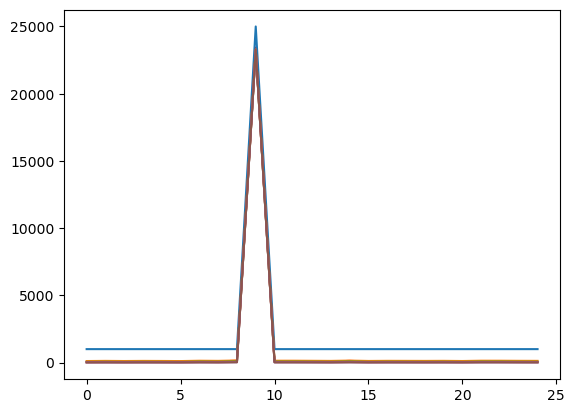

In [17]:
plt.plot(naive_est[:,0,0].real, linestyle='--', color='red')
for gr in track: 
    print(gr[20,0,0].real)
    plt.plot(gr[:,0,0].real)

In [257]:
Qs

[Array(nan, dtype=float32),
 Array(-280947.06, dtype=float32),
 Array(-468545.1, dtype=float32),
 Array(-799592.6, dtype=float32),
 Array(-1422210.9, dtype=float32),
 Array(-2634345.2, dtype=float32)]

In [265]:
mus.shape

(50, 2, 50)

In [261]:
Qs = []
gamma_init = jnp.linalg.inv(gamma_inv_init[nz,:,:]) 
Q_init = calc_Q(gamma_init, data, obs_var)
Qs.append(Q_init)
for gr in track: 
    Q_r = calc_Q(gr, data, obs_var)
    Qs.append(Q_r)

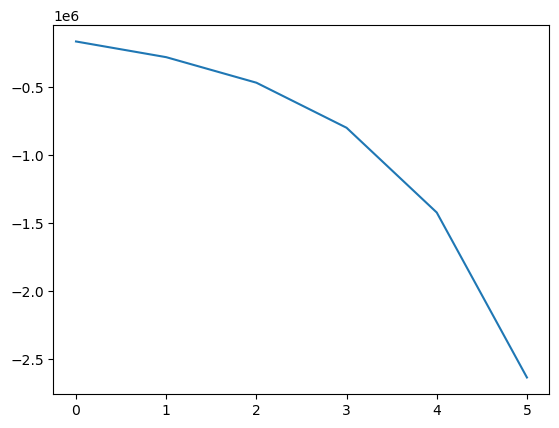

In [262]:
plt.plot(jnp.array(Qs))

In [186]:
def calc_Q(gamma_est, data, obs_var):
    T = data.shape[0]
    N = int(T/2)
    L = data.shape[-1]
    Nnz = gamma_est.shape[0]
    K = gamma_est.shape[1]

    zs_est = jnp.zeros((N,K,L), dtype=complex)
    zs_est = zs_est.at[nz,:,:].set(mus)
    zs_est_0dc = jnp.apply_along_axis(add0, 0, zs_est)
    xs_est = jnp.fft.irfft(zs_est_0dc, axis=0)
    yyT = jnp.einsum('tkl,ikl->tikl', data, data)
    yxT = jnp.einsum('tkl,ikl->tikl', data, xs_est)
    xyT = jnp.einsum('tkl,ikl->tikl', xs_est, data)
    xxT = jnp.einsum('tkl,ikl->tikl', xs_est, xs_est)
    Q_obs_sum = yyT - yxT - xyT + xxT

    a = -(T/2)*(jnp.log(2*jnp.pi) + jnp.log(obs_var))
    Q_obs_sum = yyT - yxT - xyT + xxT
    b = -(1/2)*jnp.trace(Q_obs_sum, axis1=0, axis2=1).sum()*(1/obs_var)

    c = -( (Nnz*K)*jnp.log(jnp.pi) + jnp.log(jnp.linalg.det(gamma_est).real).sum() )
    gamma_est_inv = jnp.linalg.inv(gamma_est)
    temp = jnp.einsum('jki,jinl->jknl', gamma_est_inv, zs_est_outer)
    d = -jnp.trace(temp, axis1=1, axis2=2).real.sum()
    Q_val = a + b + c + d

    return Q_val

In [187]:
test = calc_Q(gamma_update, obs, obs_var)

In [178]:
c = -( (Nnz*K)*jnp.log(jnp.pi) + jnp.log(jnp.linalg.det(gamma_update).real).sum() )
temp = jnp.einsum('jki,jinl->jknl', gu_inv, zs_est_outer)
d = -jnp.trace(temp, axis1=1, axis2=2).real.sum()
Q_val = a + b + c + d

In [180]:
for g

[Array([[[595.0025  -1.2951114e-06j,  62.449898-9.4645996e+01j],
         [ 62.449898+9.4645996e+01j, 572.8356  -4.2337786e-07j]]],      dtype=complex64),
 Array([[[2371.5334 +1.8218689e-06j,  249.79689-3.7857980e+02j],
         [ 249.79689+3.7857980e+02j, 2282.8667 -2.7554872e-06j]]],      dtype=complex64),
 Array([[[2377.5044-6.1902728e-07j,  249.8001-3.7858484e+02j],
         [ 249.8001+3.7858475e+02j, 2288.8364+6.9127077e-06j]]],      dtype=complex64),
 Array([[[2377.5095 +2.6556156e-06j,  249.79953-3.7858389e+02j],
         [ 249.79953+3.7858389e+02j, 2288.8418 +2.2935017e-06j]]],      dtype=complex64),
 Array([[[2377.5095 +2.5198794e-06j,  249.79953-3.7858389e+02j],
         [ 249.79953+3.7858389e+02j, 2288.8418 +2.3002435e-06j]]],      dtype=complex64)]

In [133]:
zs_est_outer = jnp.einsum('jkl,jil->jkil', zs_est, zs_est.conj())
zs_est_outer = zs_est_outer[9,:,:,:][None,:,:]

In [177]:
# gu_inv = jnp.linalg.inv(gamma_update)
gu_inv.shape
zs_est_outer.shape


Array(99.97772, dtype=float32)

In [165]:
j = 0
conf = jnp.zeros((Nnz,K,K,L), dtype=complex)
conf2 = jnp.zeros((Nnz,K,K,L), dtype=complex)
for l in range(L):
    conf = conf.at[j,:,:,l].set(gu_inv[j,:,:] @ zs_est_outer[j,:,:,l])
    conf2 = conf.at[j,:,:,l].set(jnp.einsum('ki,mn->kn', gu_inv[j,:,:], zs_est_outer[j,:,:,l]))


In [167]:
l = 5
print(test[0,:,:,l])
print(conf2[0,:,:,l])

[[ 0.8177617 +0.12327264j -0.04294437+1.1945964j ]
 [ 0.04102227-1.111097j    1.6023674 -0.12327266j]]
[[ 0.8177617 +0.12327264j -0.04294437+1.1945964j ]
 [ 0.04102227-1.111097j    1.6023674 -0.12327266j]]


In [120]:
jnp.linalg.inv(gamma_update)

Array([[[ 4.3713406e-04-9.2072595e-13j, -4.7707923e-05+7.2303788e-05j],
        [-4.7707923e-05-7.2303781e-05j,  4.5406827e-04-3.4607243e-13j]]],      dtype=complex64)

In [ ]:
def Q(data, gamma, gamma_prev, obs_var):




In [16]:
# gamma_full[nz,:,:]
gamma_nonzero_init

Array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]], dtype=complex64)

In [17]:
gamma_update

Array([[[2288.599  -4.9331275e-06j,  587.07056-7.2724750e+02j],
        [ 587.07056+7.2724750e+02j, 2561.0393 -7.5711171e-07j]]],      dtype=complex64)

In [13]:
i = 1
mus[:,:,:,num_devices*i]

NameError: name 'num_devices' is not defined

In [91]:
gamma_nonzero_init

Array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]], dtype=complex64)

In [80]:
check_hess[:,:,:,9]

Array([[[ 0.02086957+5.5879357e-11j, -0.00017391-1.7391305e-04j],
        [-0.00017391+1.7391305e-04j,  0.02086957+5.5879357e-11j]]],      dtype=complex64)

In [83]:
us[:,:,:,1]

Array([[[47.923313+0.j,  0.      +0.j],
        [ 0.      +0.j, 47.923317+0.j]]], dtype=complex64)

In [71]:
jnp.linalg.inv(check_hess[:,:,:,2])

Array([[[47.923313  -1.2848005e-07j,  0.39936095+3.9936095e-01j],
        [ 0.39936092-3.9936095e-01j, 47.923317  -1.2837674e-07j]]],      dtype=complex64)